In [134]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# for handling and parsing email files
import email
import os
import re
import nltk

from bs4 import BeautifulSoup
from collections import Counter
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [135]:
# load ham and spam email files
ham_fnames = [name for name in sorted(os.listdir("Resources/main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("Resources/main_spam"))]

In [136]:
# Function to parse email files
def parse_email(fname, spam=False):
    directory = "Resources/main_spam" if spam else "Resources/main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)

# Parsing ham and spam emails   
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [137]:
# Function to convert HTML content to plain text
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [138]:
# Function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

# Example printing of plain text from emails
print("Ham email in plain text:\n", email_to_text(ham_emails[3]))
print("Spam email in plain text:\n", email_to_text(spam_emails[3]))

Ham email in plain text:
 > From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evi

In [139]:
# Custom transformer to convert email content to word counts
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        
        # To perform stemming
        self.stemmer = nltk.PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            # text of the email
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            # Preprocessing steps
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = plain.replace(".", "")
                plain = plain.replace(",", "")
                plain = plain.replace("!", "")
                plain = plain.replace("?", "")
                plain = plain.replace(";", "")
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                # Stem the word, and add their counts
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

In [140]:
# Custom transformer to create a word count vectorizer
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    # Train on list of word counts and build vocabulary
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        # Build a vocabulary out of total most common stems
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
    
        return self
    # Create the vector out of vocabulary
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
                
        return X_new

In [141]:
# Pipeline to transform emails into word count vectors
email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

In [142]:
X = np.array(ham_emails + spam_emails, dtype='object')
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

In [143]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (7479,) (7479,)
Testing set size:  (1870,) (1870,)


In [144]:
# prepare the training and testing set 
X_train_prepared = email_to_cvector.fit_transform(X_train)
X_train_prepared

X_test_prepared = email_to_cvector.transform(X_test)
X_test_prepared

array([[  2,   0,   0, ...,   0,   0,  37],
       [ 23,  21,   0, ...,   0,   0, 168],
       [  2,   3,   0, ...,   0,   0,  19],
       ...,
       [ 16,   7,   0, ...,   0,   0,  63],
       [ 31,  41,  33, ...,   0,   0, 164],
       [  0,   4,   0, ...,   0,   0,  22]])

In [145]:
#Function to run the model and return the matrix
def classification_models(model, X_train_prepared, X_test_prepared, y_train, y_test):
    model.fit(X_train_prepared, y_train)
    model_prediction = model.predict(X_test_prepared)
    
    matrix = confusion_matrix(y_test, model_prediction)
    return matrix  # Return the confusion matrix

In [146]:
models = [
    RandomForestClassifier(random_state=3301),
    LogisticRegression(solver="lbfgs", random_state=3301),
    DecisionTreeClassifier(random_state=3301)
]

# Run your models and get the confusion matrices along with their names
confusion_matrices = []
model_names = []
classification_reports = [] 

for model in models:
    matrix = classification_models(model, X_train_prepared, X_test_prepared, y_train, y_test)
    confusion_matrices.append(matrix)
    model_names.append(type(model).__name__)  # Get model names
    report = classification_report(y_test, model.predict(X_test_prepared), output_dict=True)
    classification_reports.append(report)  # Store classification reports

/Users/sam/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


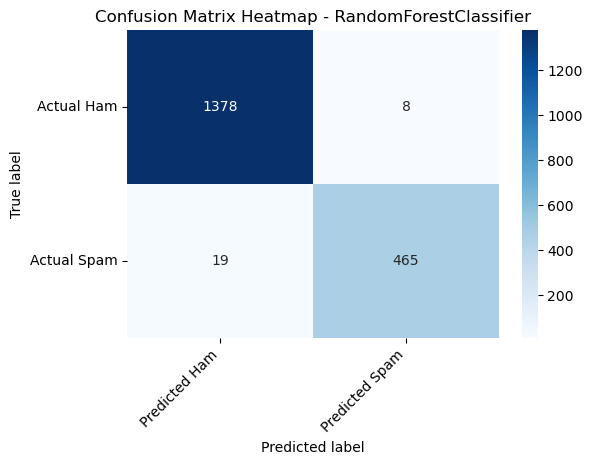

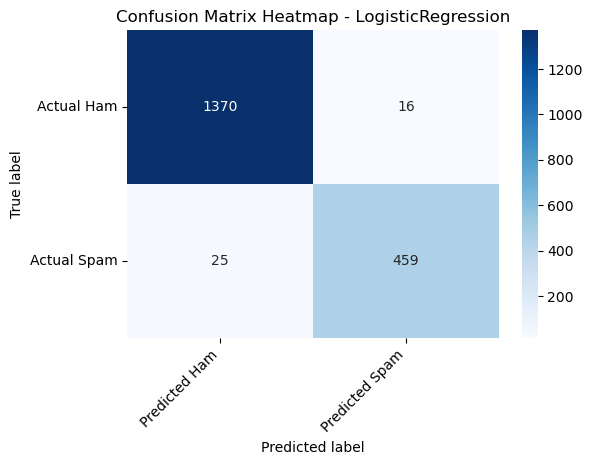

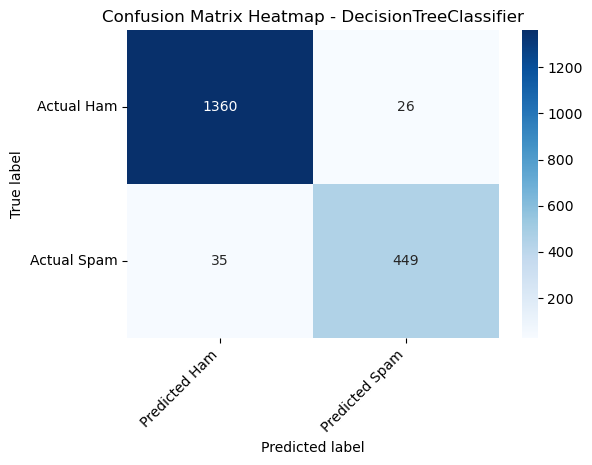

In [147]:
# Create heat maps for confusion matrices using Pandas and Seaborn
def plot_confusion_matrix(matrix, title):
    df_cm = pd.DataFrame(
        matrix, 
        index=["Actual Ham", "Actual Spam"], 
        columns=["Predicted Ham", "Predicted Spam"]
    )
    plt.figure(figsize=(6, 4))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix Heatmap - {title}')  # Use the provided title
    plt.show()

# Plot heat maps for each confusion matrix with respective model names as titles
for matrix, name in zip(confusion_matrices, model_names):
    plot_confusion_matrix(matrix, name)

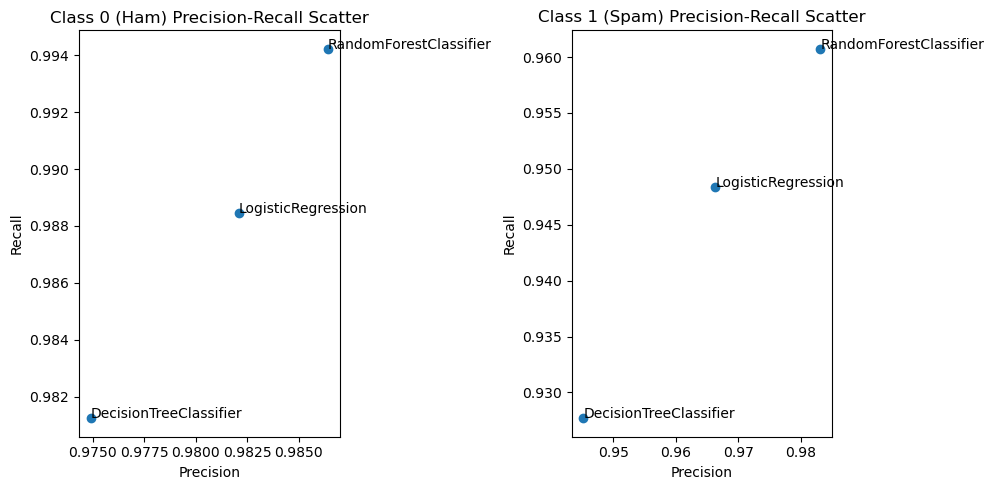

In [148]:
# Extract precision and recall for each class from classification reports
class_0_precision_recall = [(report['0']['precision'], report['0']['recall']) for report in classification_reports]
class_1_precision_recall = [(report['1']['precision'], report['1']['recall']) for report in classification_reports]

# Create scatter plots for precision-recall values for both classes across models
plt.figure(figsize=(10, 5))

# Scatter plot for class 0 (Ham)
plt.subplot(1, 2, 1)
plt.scatter([pair[0] for pair in class_0_precision_recall], [pair[1] for pair in class_0_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Class 0 (Ham) Precision-Recall Scatter')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (class_0_precision_recall[i][0], class_0_precision_recall[i][1]))

# Scatter plot for class 1 (Spam)
plt.subplot(1, 2, 2)
plt.scatter([pair[0] for pair in class_1_precision_recall], [pair[1] for pair in class_1_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Class 1 (Spam) Precision-Recall Scatter')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (class_1_precision_recall[i][0], class_1_precision_recall[i][1]))

plt.tight_layout()
plt.show()


In [149]:
#C reate oversampled data
oversample = RandomOverSampler(sampling_strategy = "minority")
X_over, y_over = oversample.fit_resample(X_train_prepared, y_train)

In [150]:
#Similar function for oversampled data
def oversampled_models(os_model, X_over, X_test_prepared, y_over, y_test):
    os_model.fit(X_over, y_over)
    model_prediction = os_model.predict(X_test_prepared)
    
    matrix = confusion_matrix(y_test, model_prediction)
    return matrix  # Return the confusion matrix

/Users/sam/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


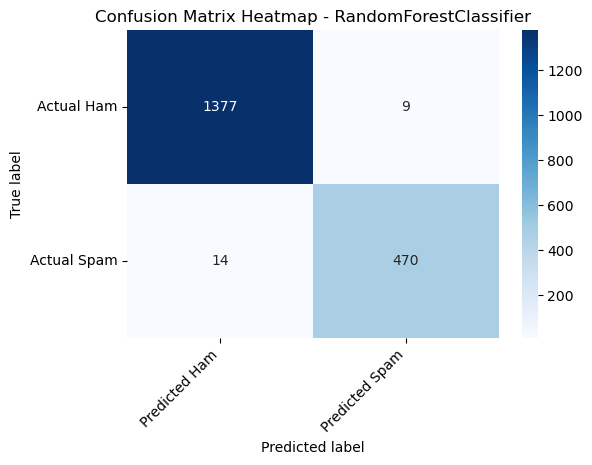

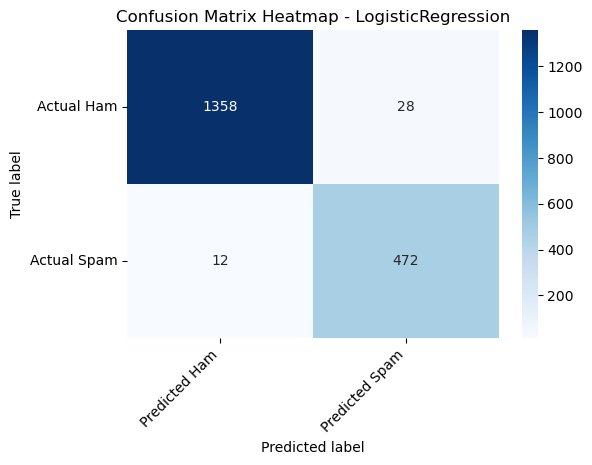

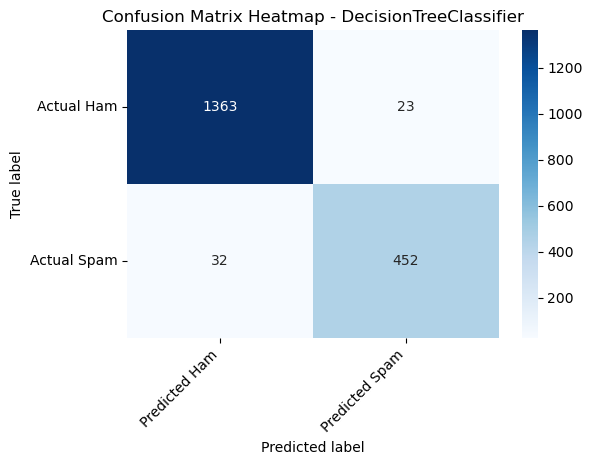

In [151]:
os_models = [
    RandomForestClassifier(),
    LogisticRegression(solver="lbfgs"),
    DecisionTreeClassifier()
]
# Run oversampled models and get the confusion matrices along with their names
oversampled_matrices = []
oversampled_model_names = []
oversampled_classification_reports = []  # To store classification reports
for os_model in os_models:
    matrix = oversampled_models(os_model, X_over, X_test_prepared, y_over, y_test)
    oversampled_matrices.append(matrix)
    oversampled_model_names.append(type(os_model).__name__)  # Get model names
    report = classification_report(y_test, os_model.predict(X_test_prepared), output_dict=True)
    oversampled_classification_reports.append(report)  # Store classification reports

for matrix, name in zip(oversampled_matrices, oversampled_model_names):
    plot_confusion_matrix(matrix, name)


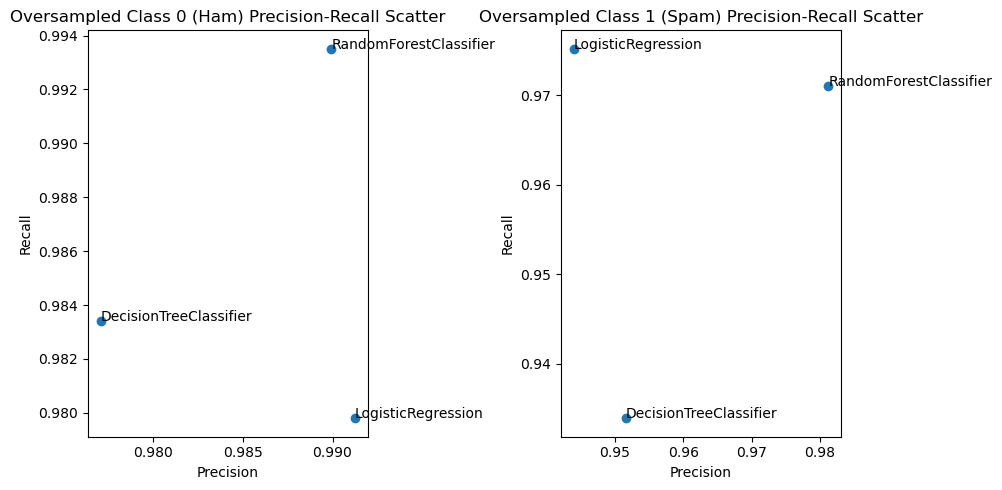

In [152]:
# Extract precision and recall for each class from oversampled classification reports
os_class_0_precision_recall = [(report['0']['precision'], report['0']['recall']) for report in oversampled_classification_reports]
os_class_1_precision_recall = [(report['1']['precision'], report['1']['recall']) for report in oversampled_classification_reports]

# Create scatter plots for precision-recall values for oversampled models for both classes
plt.figure(figsize=(10, 5))

# Scatter plot for oversampled class 0 (Ham)
plt.subplot(1, 2, 1)
plt.scatter([pair[0] for pair in os_class_0_precision_recall], [pair[1] for pair in os_class_0_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Oversampled Class 0 (Ham) Precision-Recall Scatter')
for i, txt in enumerate(oversampled_model_names):
    plt.annotate(txt, (os_class_0_precision_recall[i][0], os_class_0_precision_recall[i][1]))

# Scatter plot for oversampled class 1 (Spam)
plt.subplot(1, 2, 2)
plt.scatter([pair[0] for pair in os_class_1_precision_recall], [pair[1] for pair in os_class_1_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Oversampled Class 1 (Spam) Precision-Recall Scatter')
for i, txt in enumerate(oversampled_model_names):
    plt.annotate(txt, (os_class_1_precision_recall[i][0], os_class_1_precision_recall[i][1]))

plt.tight_layout()
plt.show()

In [153]:
#Create undersampled data
undersample= RandomUnderSampler(sampling_strategy=0.50)
X_under, y_under = undersample.fit_resample(X_train_prepared, y_train)

In [154]:
# Similar function for undersampled data
def undersampled_models(us_model, X_under, X_test_prepared, y_under, y_test):
    us_model.fit(X_under, y_under)
    model_prediction = us_model.predict(X_test_prepared)
    
    matrix = confusion_matrix(y_test, model_prediction)
    return matrix  # Return the confusion matrix

/Users/sam/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


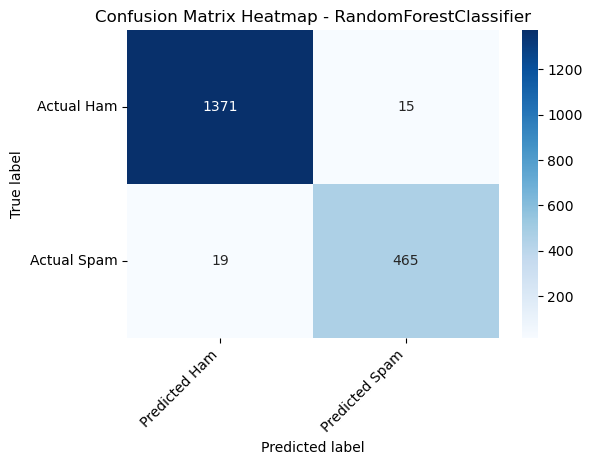

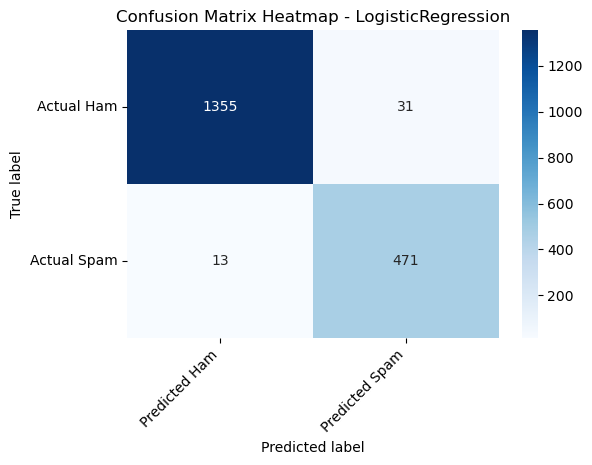

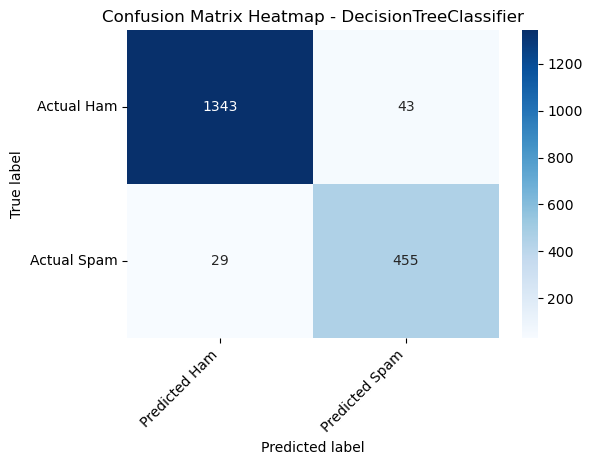

In [155]:
us_models = [
    RandomForestClassifier(n_estimators=100, random_state=0, max_depth=50, min_samples_split=40, bootstrap=False, ccp_alpha=0.000008),
    LogisticRegression(solver="lbfgs"),
    DecisionTreeClassifier()
]

undersampled_matrices = []
undersampled_model_names = []
undersampled_classification_reports = []  # To store classification reports
for us_model in us_models:
    matrix = undersampled_models(us_model, X_under, X_test_prepared, y_under, y_test)
    undersampled_matrices.append(matrix)
    undersampled_model_names.append(type(us_model).__name__)  # Get model names
    report = classification_report(y_test, us_model.predict(X_test_prepared), output_dict=True)
    undersampled_classification_reports.append(report)  # Store classification reports

# Plot heat maps for each confusion matrix of undersampled models with respective model names as titles
for matrix, name in zip(undersampled_matrices, undersampled_model_names):
    plot_confusion_matrix(matrix, name)

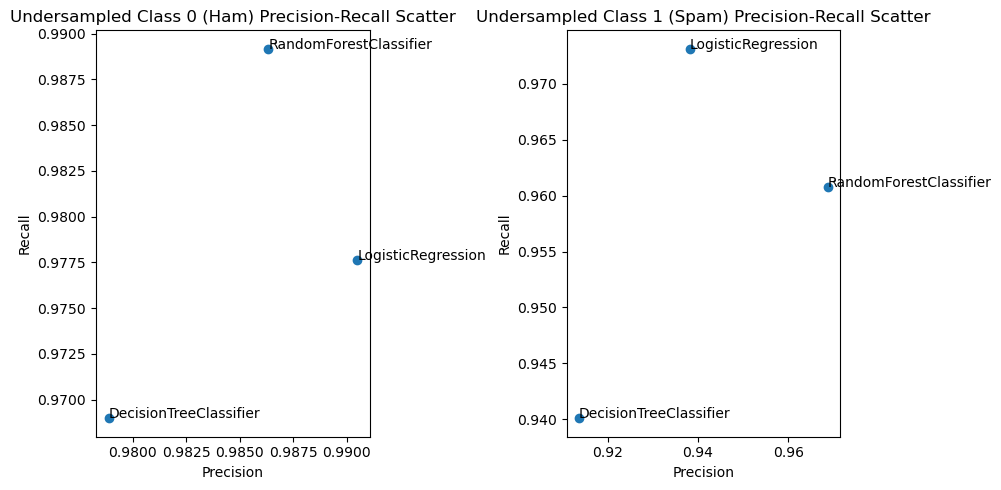

In [156]:
# Extract precision and recall for each class from undersampled classification reports
us_class_0_precision_recall = [(report['0']['precision'], report['0']['recall']) for report in undersampled_classification_reports]
us_class_1_precision_recall = [(report['1']['precision'], report['1']['recall']) for report in undersampled_classification_reports]

# Create scatter plots for precision-recall values for undersampled models for both classes
plt.figure(figsize=(10, 5))

# Scatter plot for undersampled class 0 (Ham)
plt.subplot(1, 2, 1)
plt.scatter([pair[0] for pair in us_class_0_precision_recall], [pair[1] for pair in us_class_0_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Undersampled Class 0 (Ham) Precision-Recall Scatter')
for i, txt in enumerate(undersampled_model_names):
    plt.annotate(txt, (us_class_0_precision_recall[i][0], us_class_0_precision_recall[i][1]))

# Scatter plot for undersampled class 1 (Spam)
plt.subplot(1, 2, 2)
plt.scatter([pair[0] for pair in us_class_1_precision_recall], [pair[1] for pair in us_class_1_precision_recall], marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Undersampled Class 1 (Spam) Precision-Recall Scatter')
for i, txt in enumerate(undersampled_model_names):
    plt.annotate(txt, (us_class_1_precision_recall[i][0], us_class_1_precision_recall[i][1]))

plt.tight_layout()
plt.show()

In [157]:
def classification_models_2(model, X_train_prepared, X_test_prepared, y_train, y_test):
    model.fit(X_train_prepared, y_train)
    model_prediction = model.predict(X_test_prepared)
    
    matrix = confusion_matrix(y_test, model_prediction)
    return matrix  # Return the confusion matrix


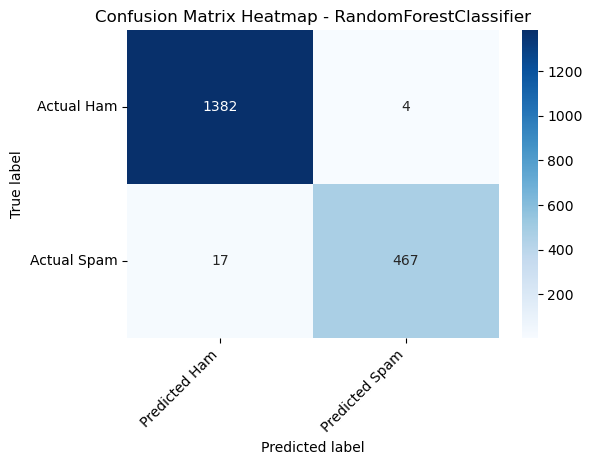

In [158]:
models = [
    RandomForestClassifier(n_estimators=80, random_state=3301, max_depth=40, min_samples_split=25, bootstrap=False, ccp_alpha=0.0000008)
]

# Run classification_models_2 for each model and get confusion matrices and model names
class_2_matrices = []
class_2_model_names = []
class_2_classification_reports = []  # To store classification reports
for model in models:
    matrix = classification_models_2(model, X_train_prepared, X_test_prepared, y_train, y_test)
    class_2_matrices.append(matrix)
    class_2_model_names.append(type(model).__name__)  # Get model names
    report = classification_report(y_test, model.predict(X_test_prepared), output_dict=True)
    class_2_classification_reports.append(report)  # Store classification reports

# Plot heat maps for each confusion matrix of classification_models_2 with respective model names as titles
for matrix, name in zip(class_2_matrices, class_2_model_names):
    plot_confusion_matrix(matrix, name)

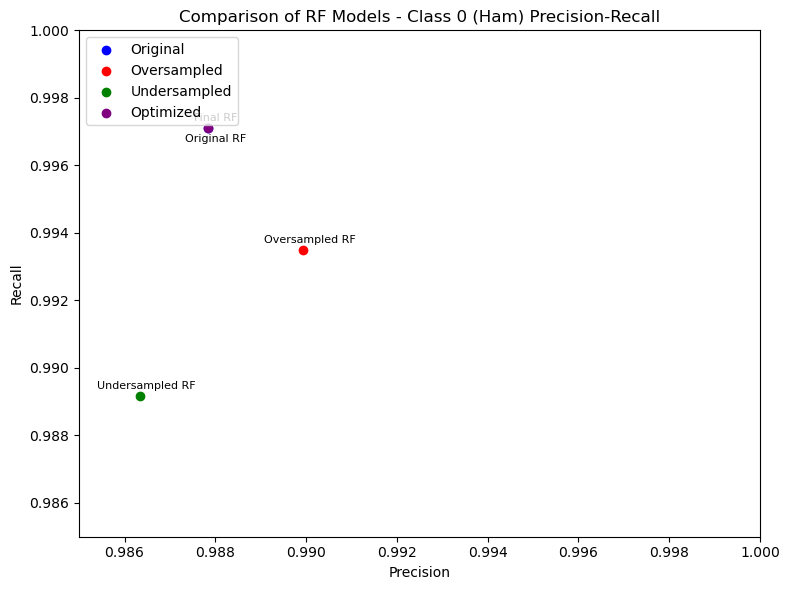

In [176]:
# Extract precision and recall for each class for different Random Forest models
original_rf_report = classification_report(y_test, models[0].predict(X_test_prepared), output_dict=True)
oversampled_rf_report = classification_report(y_test, os_models[0].predict(X_test_prepared), output_dict=True)
undersampled_rf_report = classification_report(y_test, us_models[0].predict(X_test_prepared), output_dict=True)
final_rf_report = classification_report(y_test, models[-1].predict(X_test_prepared), output_dict=True)

# Extract precision and recall values for class 0 (Ham) and class 1 (Spam) from reports
original_rf_class_0 = (original_rf_report['0']['precision'], original_rf_report['0']['recall'])
original_rf_class_1 = (original_rf_report['1']['precision'], original_rf_report['1']['recall'])

oversampled_rf_class_0 = (oversampled_rf_report['0']['precision'], oversampled_rf_report['0']['recall'])
oversampled_rf_class_1 = (oversampled_rf_report['1']['precision'], oversampled_rf_report['1']['recall'])

undersampled_rf_class_0 = (undersampled_rf_report['0']['precision'], undersampled_rf_report['0']['recall'])
undersampled_rf_class_1 = (undersampled_rf_report['1']['precision'], undersampled_rf_report['1']['recall'])

final_rf_class_0 = (final_rf_report['0']['precision'], final_rf_report['0']['recall'])
final_rf_class_1 = (final_rf_report['1']['precision'], final_rf_report['1']['recall'])

# Create a scatter plot comparing precision-recall values for different Random Forest models
plt.figure(figsize=(8, 6))

# Scatter plot for class 0 (Ham)
plt.scatter(original_rf_class_0[0], original_rf_class_0[1], marker='o', color='blue', label='Original')
plt.scatter(oversampled_rf_class_0[0], oversampled_rf_class_0[1], marker='o', color='red', label='Oversampled')
plt.scatter(undersampled_rf_class_0[0], undersampled_rf_class_0[1], marker='o', color='green', label='Undersampled')
plt.scatter(final_rf_class_0[0], final_rf_class_0[1], marker='o', color='purple', label='Optimized')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Comparison of RF Models - Class 0 (Ham) Precision-Recall')
plt.legend(loc='upper left')

# Add annotations
plt.annotate('Original RF', original_rf_class_0, textcoords="offset points", xytext=(5,-10), ha='center', fontsize=8)
plt.annotate('Oversampled RF', oversampled_rf_class_0, textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)
plt.annotate('Undersampled RF', undersampled_rf_class_0, textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)
plt.annotate('Final RF', final_rf_class_0, textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)

# Set x and y axis limits from 0 to 1
plt.xlim(0.985, 1)
plt.ylim(0.985, 1)

plt.tight_layout()
plt.show()

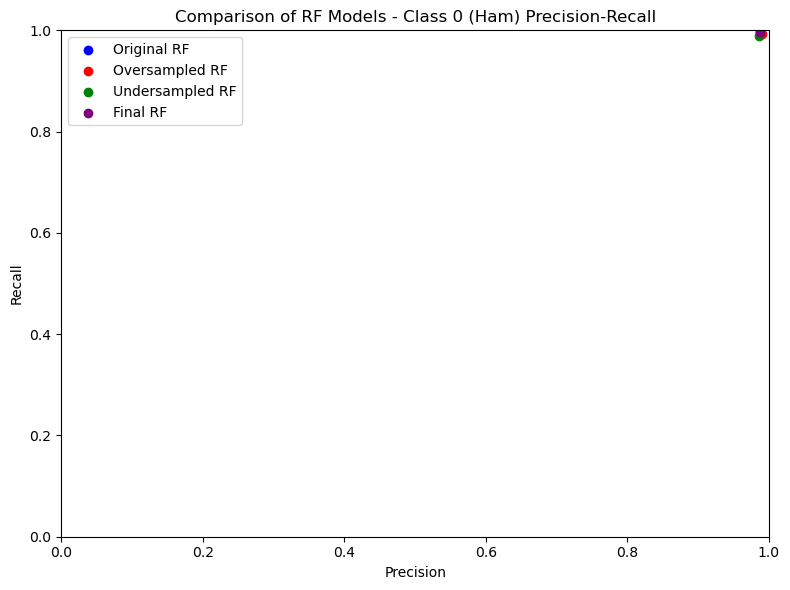

In [174]:
# Create a scatter plot comparing precision-recall values for different Random Forest models
plt.figure(figsize=(8, 6))

# Scatter plot for class 0 (Ham)
plt.scatter(original_rf_class_0[0], original_rf_class_0[1], marker='o', color='blue', label='Original RF')
plt.scatter(oversampled_rf_class_0[0], oversampled_rf_class_0[1], marker='o', color='red', label='Oversampled RF')
plt.scatter(undersampled_rf_class_0[0], undersampled_rf_class_0[1], marker='o', color='green', label='Undersampled RF')
plt.scatter(final_rf_class_0[0], final_rf_class_0[1], marker='o', color='purple', label='Final RF')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Comparison of RF Models - Class 0 (Ham) Precision-Recall')
plt.legend(loc="upper left")

# Set x and y axis limits from 0 to 1
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()